Dokładność: 1.0, F1-score: 1.0
Macierz pomyłek:
 [[843   0]
 [  0 782]]


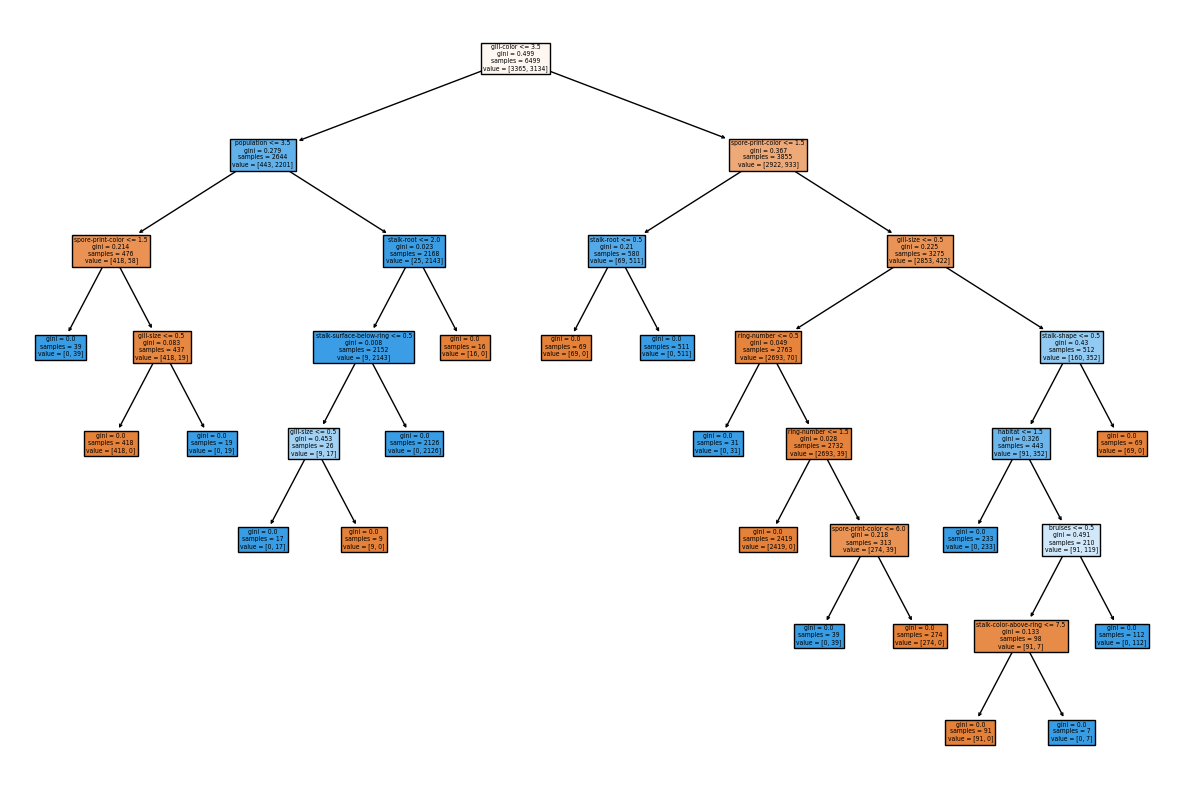

In [9]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import json

# Wczytywanie konfiguracji użytkownika
def load_config(config_path):
    with open(config_path, 'r') as file:
        return json.load(file)

# Funkcja do wyboru najlepszego podziału zgodnie z preferencjami użytkownika
def choose_best_split(feature_importances, config, possible_splits):
    threshold = config['similarity_threshold']
    sorted_features = config['feature_hierarchy']
    interactive = config['interactive_mode']
    interactive_threshold = config['interactive_threshold']
    
    best_splits = [split for split in possible_splits if abs(split['quality'] - max([s['quality'] for s in possible_splits])) <= threshold]
    
    if len(best_splits) > 1:
        best_splits.sort(key=lambda x: sorted_features.index(x['feature']) if x['feature'] in sorted_features else len(sorted_features))
        
        if interactive and abs(best_splits[0]['quality'] - best_splits[-1]['quality']) <= interactive_threshold:
            print("Wybierz cechę do podziału spośród:")
            for i, split in enumerate(best_splits):
                print(f"{i}: {split['feature']} (jakość: {split['quality']})")
            choice = int(input("Podaj numer cechy: "))
            return best_splits[choice]['feature']
        
    return best_splits[0]['feature']

# Klasa rozszerzająca drzewo decyzyjne
def custom_decision_tree(X_train, y_train, config, is_regression=False):
    model = DecisionTreeRegressor() if is_regression else DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model

# Funkcja testowania modelu
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    print(f"Dokładność: {accuracy}, F1-score: {f1}")
    print("Macierz pomyłek:\n", cm)
    return accuracy, f1

# Główna funkcja przetwarzania danych
def process_data(file_path, target_column, config, is_regression=False):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = custom_decision_tree(X_train, y_train, config, is_regression)
    evaluate_model(model, X_test, y_test)
    
    plt.figure(figsize=(15, 10))
    plot_tree(model, feature_names=X.columns, filled=True)
    plt.show()

# Przykładowe użycie
config = {
    "similarity_threshold": 0.1,
    "feature_hierarchy": ["odor", "gill-color", "cap-shape"],
    "interactive_mode": True,
    "interactive_threshold": 1
}

# Wczytanie i przetworzenie danych
process_data("datasets/mushroom.csv", "class", config, is_regression=False)
